# INITIALIZE

In [106]:
## include packages

using DelimitedFiles
using GaussDCA
using DCAUtils
using Plots
using FastaIO
using StatsBase
using Random
using MultivariateStats
using Statistics
using KitMSA
using PyPlot
using PyCall
using Distributions
using NaNStatistics
using LaTeXStrings
using DataFrames
using Suppressor
using CSV

@pyimport seaborn as sns
@pyimport numpy as np
@pyimport scipy.stats as stats
@pyimport matplotlib.colors as cols
@pyimport matplotlib.cm as mtcm
@pyimport matplotlib.ticker as tick


In [2]:
## load model parameters 

PATH_PAR = "../../../Research/Projects/Project_nobu/DCAparam/param_Thornton/Parameters_conv_Thr-PCD40.dat"
h, J = KitMSA.extract_params(PATH_PAR;q=21)
;

In [324]:
## define functions

function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topright)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end


function adjust_two_point(matrix, freqs)
    N = Int.(length(freqs)/20)
    q = 20
    for i in 1:N
        for j in 1:N
            for a in 1:20
                for b in 1:20
                    if i != j 
                        matrix[a+(i-1)*q , b+(j-1)*q]-=freqs[a+(i-1)*q]*freqs[b+(j-1)*q]
                    end
                end
            end
        end
    end
end


function build_seq_matrices(matrices)
    n_seqs_per_chain = length(matrices[1][:, 1])
    n_chains = length(matrices)
    return [vcat([matrices[i][j, :] for i in 1:n_chains]'...) for j in 1:n_seqs_per_chain]
end
                
function get_steps(file)
    vec_text = readlines(file)[5:4:end]
    vec_step = ["1" for i in 1:length(vec_text)]
    for (i, str) in enumerate(vec_text)
       vec_step[i] = split(str)[8]
    end
    return parse.(Int64, vec_step)
end
                            
function one_hot(msa::Array{Int8,2})
    M, N = size(msa)
    new_msa = zeros(M, N*21)
    for i in 1:M
        for j in 1:N
            index = msa[i,j]  
            new_msa[i, (j-1)*21 + index] = 1
        end
    end
    return new_msa
end

function one_hot(seq::Array{Int8,1})
    N = length(seq)
    new_msa = zeros(N*21)
    for j in 1:N
        index = seq[j]  
        new_msa[(j-1)*21 + index] = 1
    end
    return new_msa
end
                                                
function my_log2(x)
    if x == 0
        return 0                                                
    else
        return log2(x)
    end
end                                                
                                                    
                                                                                
                                                
function cie_fast(MSA)
    M, L = size(MSA)
    W, Meff = DCAUtils.compute_weights(Int8.(MSA'), 0; verbose=true)
    fi, fij = DCAUtils.compute_weighted_frequencies(Int8.(MSA'), W, Meff)
    #fi, fij = DCAUtils.add_pseudocount(fi, fij, 1/Meff)

    # Preallocate the space for p and entropy
    p = Vector{Float64}(undef, 20)
    entropy = Vector{Float64}(undef, L)

    for i in 1:L
        # Extract the relevant slice of fi just once
        fi_slice = @view fi[((i-1)*20 + 1): i*20]
        
        # Normalize p in-place
        sum_fi = sum(fi_slice)
        @. p = fi_slice / sum_fi
        
        # Compute entropy using a vectorized log2 operation
        entropy[i] = -sum(p .* my_log2.(p))
    end
    
    return entropy
end
                                                        
                                                        
function cie(MSA)
    M, L = size(MSA)
    W, Meff = DCAUtils.compute_weights(Int8.(MSA'), 0.2; verbose=true)
    fi, fij = DCAUtils.compute_weighted_frequencies(Int8.(MSA'), W, Meff)
    fi, fij = DCAUtils.add_pseudocount(fi, fij, 1/Meff)

    # Preallocate the space for p and entropy
    p = Vector{Float64}(undef, 20)
    entropy = Vector{Float64}(undef, L)

    for i in 1:L
        # Extract the relevant slice of fi just once
        fi_slice = @view fi[((i-1)*20 + 1): i*20]
        
        # Normalize p in-place
        sum_fi = sum(fi_slice)
        @. p = fi_slice / sum_fi
        
        # Compute entropy using a vectorized log2 operation
        entropy[i] = -sum(p .* my_log2.(p))
    end
    
    return entropy
end


function get_rank(vec)
    L = length(vec)
    rank = [NaN for i in 1:L]
    index_no_nan = [i for i in 1:L if !isnan(vec[i])]
    vec_no_nan = vec[index_no_nan]
    r = [percentilerank(vec_no_nan, x) for x in vec_no_nan]/100
    rank[index_no_nan] .= r
    return rank
end

function nancorspearman(v1, v2)
    not_nan = (!).(isnan.(v1) .& isnan.(v2))
    not_zero = (!).((v1 .== 0) .& (v2 .== 0))
    mask = not_nan .& not_zero                                                                        
    #v1_n = [val == 0.0 ? rand()/100 : val for val in v1[not_nan]]
    #v2_n = [val == 0.0 ? rand()/100 : val for val in v2[not_nan]]
    v1_n = v1[mask]                                                                            
    v2_n = v2[mask]
                                                                            
    return cor(invperm(sortperm(v1_n)), invperm(sortperm(v2_n)))
end                                                                    
                                                                            
              
        
function reformat_dms(df)
    dms = copy(df)
    rename!(dms,:wt_amino => :WTAA)
    rename!(dms,:var_amino => :MTAA)
    rename!(dms,:res => :SITE)
    rename!(dms,:ΔE => :FIT)
    
    dms.MTAA = [ ismissing(num) ? missing : num2letter(num) for num in dms.MTAA]
    dms.WTAA = [ ismissing(num) ? missing : num2letter(num) for num in dms.WTAA]
    
    return dms    
end
    

function get_scores(WT, names_wt, h, J, dict_seqs, df_DBD)
    k = 0
    for (key, val) in names_wt
        if val == WT
            k = key
        end
    end

    dms_sil = KitMSA.dms_silico(h, J, dict_seqs[WT])
    dms_sil = reformat_dms(dms_sil)
    dms_exp = df_DBD[  df_DBD[:, "NAME"] .== WT, :]
    dms_join = dropmissing!(innerjoin(dms_exp,dms_sil, on = ["SITE", "MTAA"], makeunique=true))

    # mask with syn muts   
    mask_syn = dms_join.WTAA .== dms_join.MTAA
    mask_not_syn = (!).(mask_syn)

    # remove unnecessary columns
    rename!(dms_join, :FIT_1 => "ΔE")
    select!(dms_join, Not(["WTAA_1"]))
            
    # normalize to wt fitness
    fit_syn = mean(dms_join.FIT[mask_syn])
    #fit_syn = mean(dms_join.FIT)
    dms_join.FIT .= dms_join.FIT .- fit_syn  

    # remove syn
    dms_join = dms_join[mask_not_syn, :]

   
    return dms_join 
end
        


get_scores (generic function with 1 method)

# DATA

In [6]:
## read alignments from evolutionary trajectories

folder_path = "../data/amino_mixed_dbd_steps600000_seqs100_T1.0p0.5/"
output_folder = "../img/paper_PNAS/DBD/"
sampler_type = "mixed"

fasta_files = filter(file -> endswith(file, ".$(sampler_type)DNA"), readdir(folder_path))
matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) for file in fasta_files]
step_matrices = build_seq_matrices(matrices)
S = length(step_matrices[1][:,1])
N = length(step_matrices[1][1,:])
println(N," ", S)
steps = pushfirst!(get_steps(joinpath(folder_path, fasta_files[1])), 0)


mean_dist_steps = [mean(pairwise_hamming(matrix)) for matrix in step_matrices]
std_dist_steps = [std(pairwise_hamming(matrix)) for matrix in step_matrices]
;  


76 100


In [13]:
## get silico and experimental evolution data

# wt sequence
wt_DBD = Int8.(readdlm("../data/alignments/thornton/wt_thornton")')[1, :]

# natural seqs
path_nat = "../data/alignments/thornton/DBD_alignment.uniref90.cov80.a2m"
nat_MSA = Int8.(fasta2matrix(path_nat))
W_nat = DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]
idxs = sample(1:length(W_nat), Weights(W_nat), S, replace=true)
trimmed_nat = nat_MSA[idxs,:]
r_nat = sample(1:size(nat_MSA, 1), S)

# hamming distance from WT, weighted
M = size(nat_MSA, 1)
mean_hamming_nat = 100*mean([KitMSA.my_hamming(wt_DBD, nat_MSA[k, :]) for k in 1:M])/length(wt_DBD)
weighted_mean_hamming_nat = 100*sum(W_nat .* [KitMSA.my_hamming(wt_DBD, nat_MSA[k, :]) for k in 1:M])/(length(wt_DBD)*sum(W_nat))


# pairwise distance natural and sampled sequences
dp = pairwise_hamming(step_matrices[end])
dp_nat = pairwise_hamming(trimmed_nat)
;


θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [14]:
## get PCA

# one hot encoding of natural alignment
one_hot_nat = one_hot(nat_MSA)
W_nat=DCAUtils.compute_weights(Int8.(nat_MSA'),0.2)[1]

# compute covariance of data
cov_nat = cov(one_hot_nat, pweights(W_nat))

# compute eigenvalues and eigenvectors of covariance matrix
eigenvecs_nat = eigvecs(cov_nat)
eigenvals_nat = eigvals(cov_nat)

# project natural data onto principal components
pc_nat = eigenvecs_nat[:, [end, end-1]]'*one_hot_nat'

# project wts onto natural sequences pcs
oh_anc_dbd = one_hot(wt_DBD)
pc_anc_dbd = eigenvecs_nat[:, [end, end-1]]'*oh_anc_dbd
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [213]:
## get wts

# input data path
path_joe = "../../../Research/Projects/Project_nobu/dms_data/mixed_to_check_divergence/data_thornton/dF.txt"

# create dataframe
df_exp_joe = DataFrame()
@suppress_err begin
    df_exp_joe = DataFrame(CSV.File(path_joe; types = [Int64, Int64, String, String, Float64, Float64, Float64]))
end

# select the 8 relevant wts
wt_MAP =    [1,    4,    6, 7, 8, 10, 12, 14, 19] # maximum a posteriori reconstructed wt
wt_AltAll = [2,    5,          9, 11,         20] # alternative reconstructed wt
wt_all = vcat(wt_MAP, wt_AltAll) # all wts

nwt = length(wt_all)   

# get wts sequences for all wts
wt_vec = [ [] for i in 1:nwt ]
for (i, ind) in enumerate(sel_wt)
    wt_aminos = df_exp_joe[  df_exp_joe[:, "PROT"] .== ind, "WTAA"]
    wt_vec[i] = wt_aminos[1:20:end]
end

L = size(h, 2)
wt_vec_num = [  [ letter2num.(wt_vec[i][k][1]) for k in 1:L] for i in 1:tot_wt]
names_wt = Dict(1=> "AncNR3", 2=> "AncNR3 AA", 4 => "AncSR1",5 => "AncSR1 AA" ,6 => "Anellid SR", 
    7 => "Sedentarian SR", 8 => "Scolecid SR",9 => "Scolecid SR AA", 10 => "AncSR",11 => "AncSR AA", 12 => "C. teleta SR", 
    14 => "Human GR", 19 => "Protostome SR", 20 => "Protostome SR AA")
dict_seqs = Dict( names_wt[wt_all[i]] => wt_vec_num[i] for i in 1:nwt )


Dict{String,Array{Int64,1}} with 14 entries:
  "AncSR1 AA"        => [2, 1, 18, 2, 6, 3, 20, 1, 16, 6  …  11, 9, 6, 6, 18, 1…
  "C. teleta SR"     => [2, 14, 8, 2, 3, 3, 1, 1, 16, 6  …  16, 15, 6, 12, 2, 1…
  "AncSR1"           => [2, 1, 18, 2, 16, 3, 20, 1, 16, 6  …  11, 9, 6, 6, 8, 1…
  "AncNR3"           => [2, 10, 18, 2, 6, 3, 15, 1, 16, 6  …  11, 9, 4, 6, 18, …
  "AncSR AA"         => [2, 1, 18, 2, 6, 3, 20, 1, 16, 6  …  11, 9, 6, 6, 18, 1…
  "Anellid SR"       => [2, 14, 8, 2, 12, 3, 18, 1, 16, 6  …  17, 9, 6, 12, 16,…
  "Scolecid SR AA"   => [2, 14, 8, 2, 12, 3, 1, 1, 16, 6  …  16, 15, 6, 12, 16,…
  "Protostome SR"    => [2, 14, 18, 2, 12, 3, 20, 1, 16, 6  …  17, 9, 6, 16, 14…
  "AncNR3 AA"        => [2, 10, 18, 2, 6, 3, 20, 1, 16, 6  …  10, 9, 4, 6, 18, …
  "Sedentarian SR"   => [2, 14, 8, 2, 12, 3, 18, 1, 16, 6  …  17, 9, 6, 12, 16,…
  "AncSR"            => [2, 1, 18, 2, 12, 3, 20, 1, 16, 6  …  11, 9, 6, 6, 18, …
  "Protostome SR AA" => [2, 14, 18, 2, 12, 3, 20, 1, 16, 6  …  1

In [209]:
## get dataframe with wts DBD
df_DBD = CSV.read("../../Projects/Project_nobu/dms_data/Thornton.csv", DataFrame)
df_DBD[!, "NAME"] .= [names_wt[key] for key in df_DBD.PROT]
;

In [362]:
df[SITE, "FIT"]

-1.3307530453506817

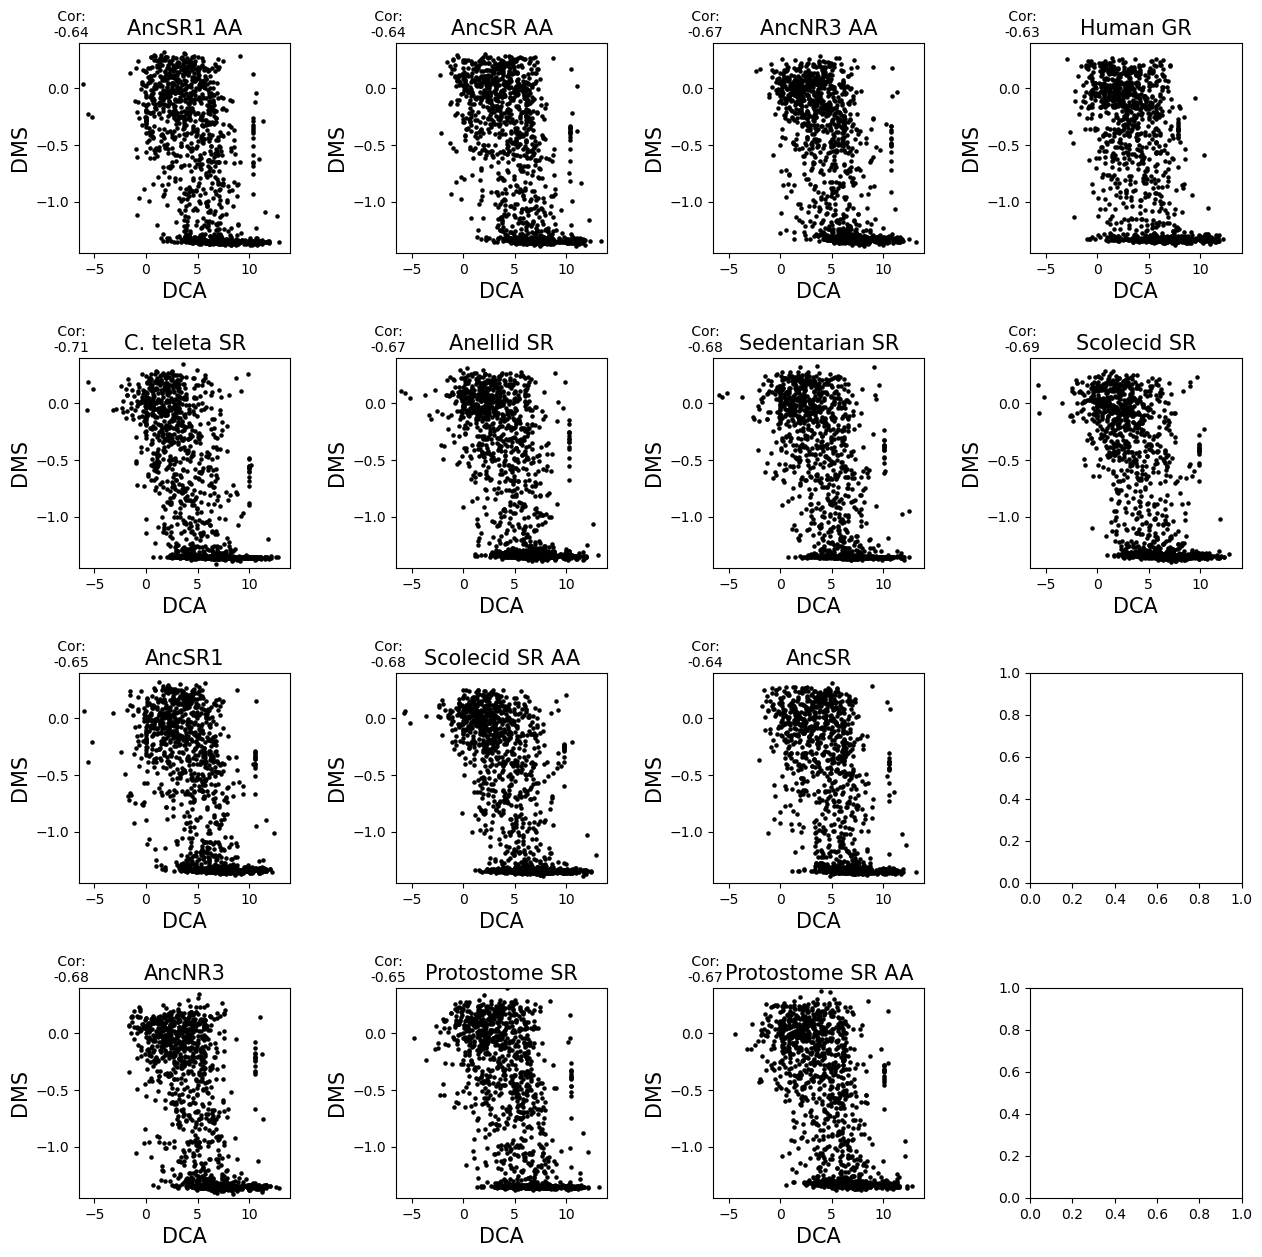

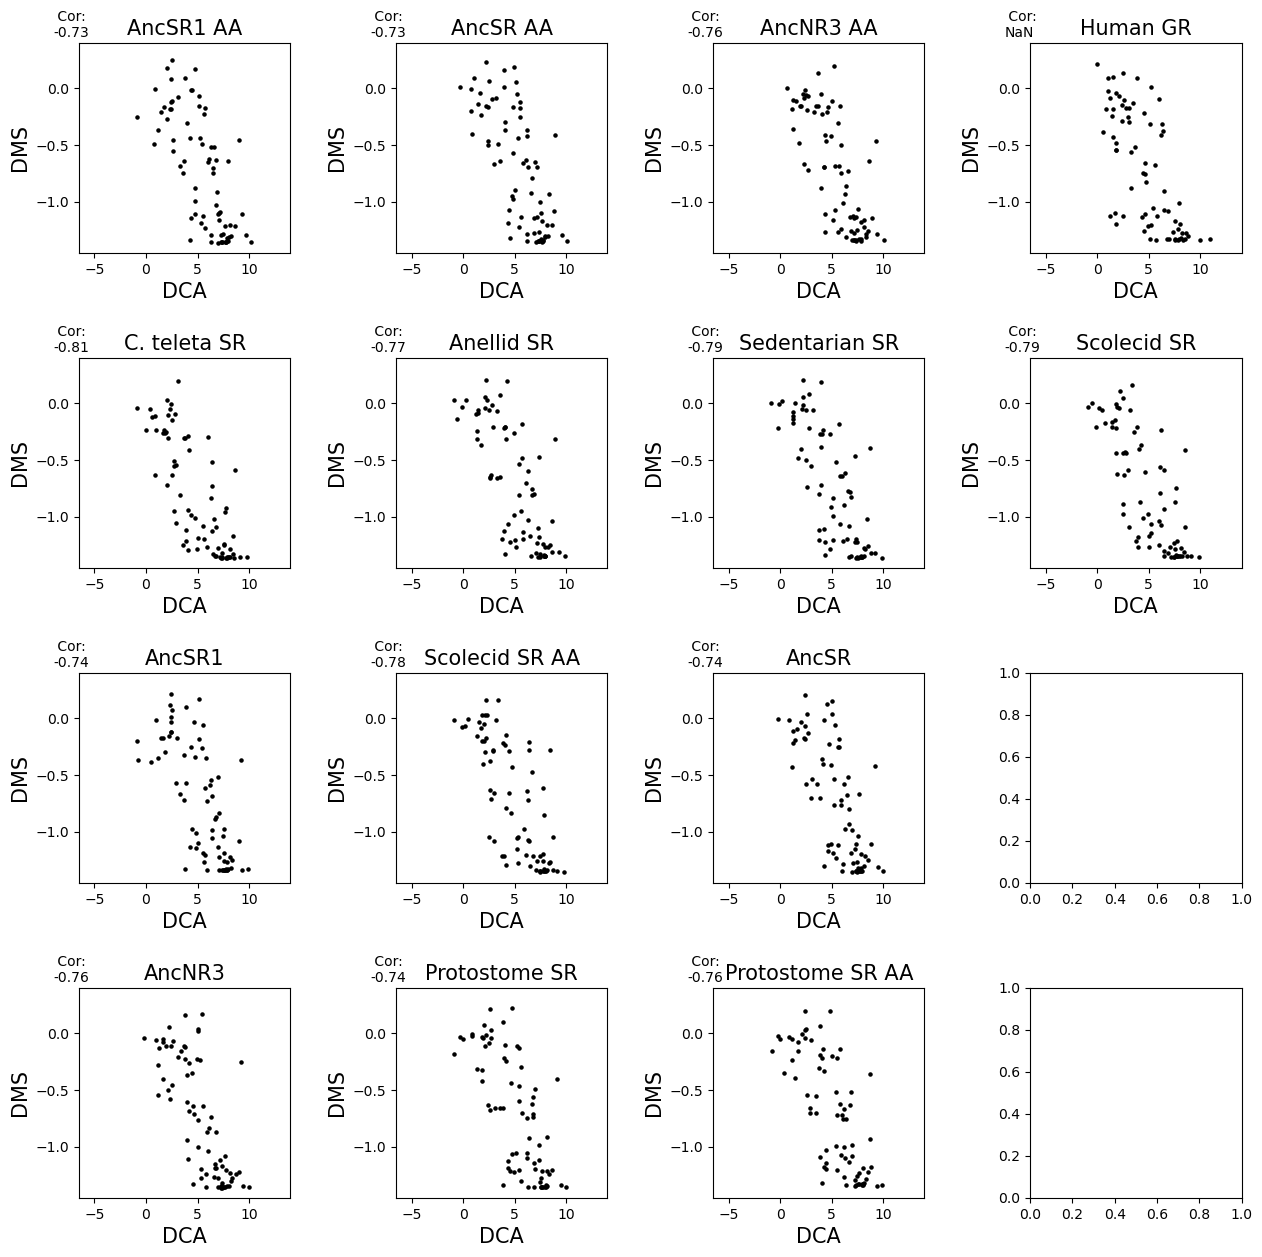

In [365]:
## Plot correlation DMS DCA for each wt

fig, ax = plt.subplots(4, 4, figsize = (15, 15))
   
subplots_adjust(wspace = 0.5, hspace = 0.5)
for (i, WT) in enumerate(keys(dict_seqs))
    df = get_scores(WT, names_wt, h, J, dict_seqs, df_DBD)
    dms = df.FIT
    dca = df.ΔE
    c = round(corspearman(dms, dca), digits = 2)
    ax[i].scatter(dca, dms, s = 5, color = "black")
    ax[i].set_title("$WT", fontsize = 15)
    ax[i].set_xlabel("DCA", fontsize = 15)
    ax[i].set_ylabel("DMS", fontsize = 15)
    ax[i].text(-9, 0.45," Cor:\n$c")
    ax[i].set_xlim(-6.5, 14)
    ax[i].set_ylim(-1.45, 0.4)
end

fig, ax = plt.subplots(4, 4, figsize = (15, 15))
   
subplots_adjust(wspace = 0.5, hspace = 0.5)
for (i, WT) in enumerate(keys(dict_seqs))
    df = get_scores(WT, names_wt, h,  J, dict_seqs, df_DBD)
    dms = [mean(df[df.SITE .== i, "FIT"]) for i in 1:L]
    #dca = [mean(df[df.SITE .== i, "ΔE"]) for i in 1:L]
    
    p_dca = exp.(-df[df.SITE .== i, "ΔE"])/sum(exp.(-df[df.SITE .== i, "ΔE"]))
    S_dca = sum(-p_dca .* log2.(p_dca))
    
    c = round(corspearman(dms, dca), digits = 2)
    ax[i].scatter(dca, dms, s = 5, color = "black")
    ax[i].set_title("$WT", fontsize = 15)
    ax[i].set_xlabel("DCA", fontsize = 15)
    ax[i].set_ylabel("DMS", fontsize = 15)
    ax[i].text(-9, 0.45," Cor:\n$c")
    ax[i].set_xlim(-6.5, 14)
    ax[i].set_ylim(-1.45, 0.4)
end

# FIGURES

In [15]:
## global parameters

fs_label = 15
fs_ax = 13
fs_leg = 11
bw_exp = 0.65
;

## FIG. 1B / 1S C

In [16]:
## rank_flag = true produces figure 1S C
## rank_flag = false produces figure 1B

rank_flag = true

true

## FIG. 1C-D / 1S A

In [69]:
## precompute quantities

# define what points of the trajectory to show
total_steps = length(steps)
traj_index = [2, 10, 40, 150, 500, total_steps]
num_curves = length(traj_index)

# compute pc along trajectory
pc_vec = [Array{Float64}(undef, 0, 2) for i in 1:num_curves]
for (i, index) in enumerate(traj_index[end:-1:1])
    one_hot_proj = one_hot(step_matrices[index])
    pc_vec[i] = eigenvecs_nat[:, [end, end-1]]'*one_hot_proj'
end

# mean hamming distance
mean_hamming = [sum([KitMSA.my_hamming(wt_DBD, step_matrices[k][i, :]) for i in 1:S])/S for k in 1:total_steps]
mean_hamming_select = [sum([KitMSA.my_hamming(wt_DBD, step_matrices[k][i, :]) for i in 1:S])/S for k in traj_index]
dist_perc = Int64.(round.(mean_hamming_select*100/length(wt_DBD), digits = 0))

;

In [74]:
## contour = true produces figure 1C-D

contour = false
bw = 1.1



1.1

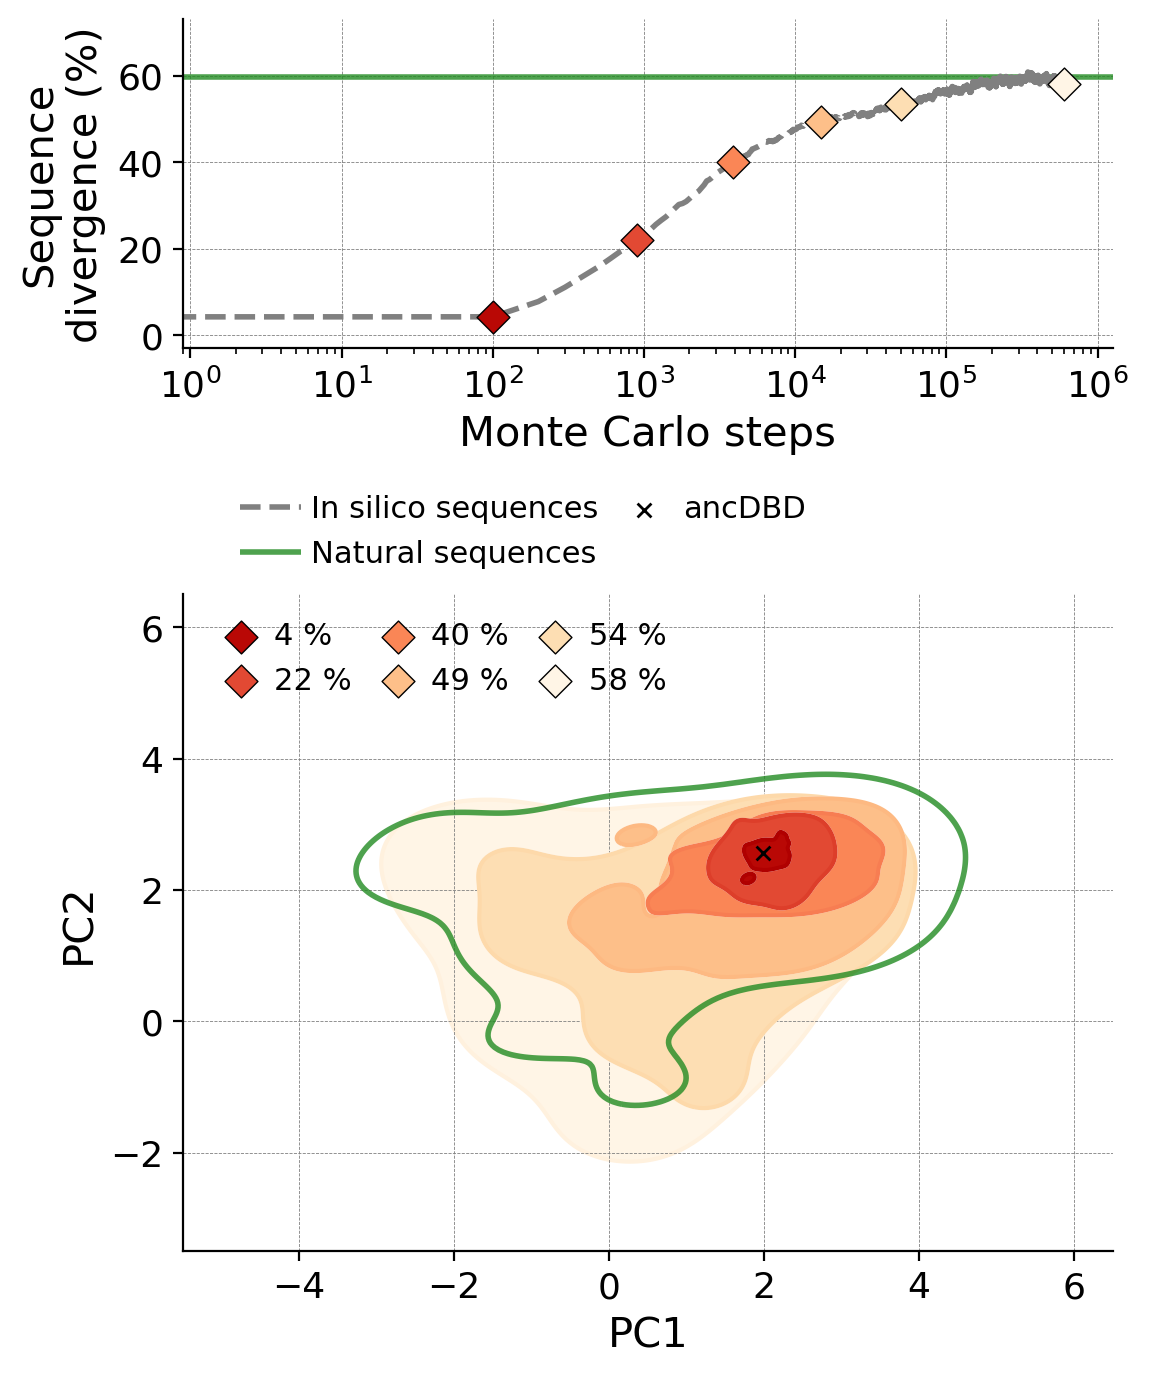

In [84]:
## plot figure

# define figure
kw = Dict("height_ratios" => [1,2])
fig, (axc, axd) = plt.subplots(2, 1, figsize = (6, 8), dpi = 200, 
gridspec_kw= kw)
subplots_adjust(hspace = 0.5)

########
## 1C ##
########

axc.spines["right"].set_visible(false)
axc.spines["top"].set_visible(false)
axc.grid(color="grey", linestyle="--", linewidth=0.3, zorder = 4)


axc.set_xscale("log")
axc.set_xlabel("Monte Carlo steps", fontsize = fs_label)
axc.set_ylabel("Sequence\ndivergence (%)", fontsize = fs_label)

axc.set_ylim(-3, 73)
axc.set_xlim(right = 10^(6.1))
axc.tick_params(axis="both", which="major", labelsize= fs_ax)



# Get the colormap
mycm = mtcm.get_cmap("OrRd")
my_color = mycm(collect(1:256))

c_vec = [ my_color[Int64(round( (i-1)/num_curves * 256 + 5)),:] for i in 1:num_curves][end:-1:1]

for (i, st) in enumerate(steps[traj_index])
    d = dist_perc[i]
    #ax.vlines(st, -5, 85, color = c_vec[i], alpha = 0.5, linewidth = 3) 
    axc.scatter(st, 100*mean_hamming_select[i]/length(wt_DBD), s = 70, 
    color = c_vec[i], marker = "D", zorder = 3, edgecolor = "black", linewidth = 0.5, 
    label = "$(d) %")
end

axc.hlines(weighted_mean_hamming_nat, 0, 10^9, color = "forestgreen", alpha = 0.8, linewidth = 2, 
linestyle = "-")

axc.plot(steps, 100*mean_hamming/length(wt_DBD), linewidth = 2, linestyle = "--",
color = "grey", label = "In silico sequences")


#axc.xaxis.set_minor_locator(tick.LogLocator(base=10, subs="auto"))
#axc.xaxis.minorticks_on()

handles_c, labels_c = axc.get_legend_handles_labels()


#axc.legend(pD, bbox_to_anchor=(0, -0.7), loc="upper left", 
#fontsize = fs_leg, ncol = 2, frameon = false, columnspacing = 0.5)


########
## 1D ##
########
axd.spines["right"].set_visible(false)
axd.spines["top"].set_visible(false)
axd.set_xlabel("PC1", fontsize = fs_label)
axd.set_ylabel("PC2", fontsize = fs_label) 
axd.set_ylim(-3.5, 6.5)
axd.set_xlim(-5.5, 6.5)

    
# define white color
w = ["white", "white"]
map_white = cols.LinearSegmentedColormap.from_list("custom_cmap", w, N=1)
b = ["black", "black"]
map_black = cols.LinearSegmentedColormap.from_list("custom_cmap", b, N=1)



# plot the densities
for i in 1:num_curves

    # get principal components
    pc = pc_vec[i]
    c_number = Int64(round( (i-1)/num_curves * 256 + 5))
    
    # new colormap
    cmap =  cols.LinearSegmentedColormap.from_list("custom_cmap", [my_color[c_number, :], 
        my_color[c_number, :]], N=num_curves)
    cmap_cont = cols.LinearSegmentedColormap.from_list("custom_cmap", [my_color[c_number + 7, :], 
        my_color[c_number, :]], N=num_curves)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = true, cmap = map_white, ax= axd, zorder = i, 
    bw_adjust = bw)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = false, cmap = map_white, ax = axd, zorder = i, 
    bw_adjust = bw)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = true, alpha = 1, cmap = cmap, ax = axd, 
    zorder = i, 
    bw_adjust = bw)
    
    sns.kdeplot(x=pc[1, :], y=pc[2, :], levels=[0.1, 1], fill = false, alpha = 1,
    cmap = cmap_cont, ax = axd, zorder = i, 
    bw_adjust = bw)
end


# contour natural sequences
color_nat = cols.LinearSegmentedColormap.from_list("custom_cmap", ["forestgreen", "forestgreen"], N=1)
sns.kdeplot(x=pc_nat[1, r_nat], y=pc_nat[2, r_nat], levels=[0.1, 1], 
fill = false, alpha = 0.8, cmap = color_nat, linestyles="-", 
label = "Natural sequences", linewidths = 2, ax= axd, zorder = num_curves + 1, 
bw_adjust = bw)


###########

# wt points
pp = axd.scatter(pc_anc_dbd[1], pc_anc_dbd[2], s = 25, marker = "x", 
color = "black", label = "ancDBD", linewidth = 1, zorder = num_curves + 1)

axd.tick_params(axis="both", which="major", labelsize=fs_ax)
axd.grid(color="grey", linestyle="--", linewidth=0.3, zorder = 4)


handles_d, labels_d = axd.get_legend_handles_labels()
handles_main = vcat(handles_c[1], handles_d)
labels_main = vcat(labels_c[1], labels_d)

handles_minor = handles_c[2:end]
labels_minor = labels_c[2:end]

axd.legend(handles_minor, labels_minor, bbox_to_anchor=(0, 1), loc="upper left", 
fontsize = fs_leg, ncol = 3, frameon = false, columnspacing = 0.5, handletextpad = 0.1)

fig.legend(handles_main, labels_main, bbox_to_anchor=(0.15, 0.6), loc="upper left", 
fontsize = fs_leg, ncol = 2, frameon = false, columnspacing = 0.5, handletextpad = 0.3)

if contour
    plt.savefig("../img/paper_PNAS/DBD/1S_A.png", bbox_inches = "tight", dpi = 300)
else
    plt.savefig("../img/paper_PNAS/DBD/1C-D.png", bbox_inches = "tight", dpi = 300)
end

#  OTHER FIGURES

## Histogram pairwise distances

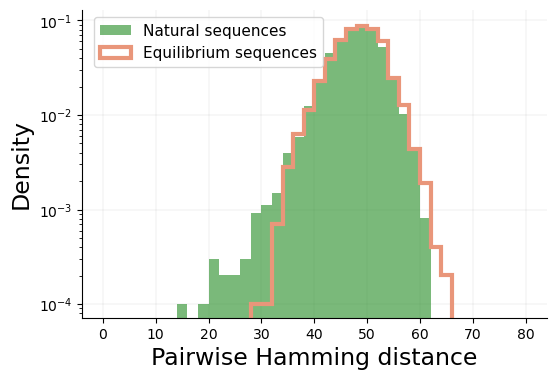

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
matplotlib.pyplot.grid(color="grey", linestyle="-", linewidth=0.3, alpha = 0.3)

plt.hist(dp_nat, bins = collect(0:2:80), alpha = 0.6, 
label = "Natural sequences", density=true, color = "forestgreen",histtype = "step",
linewidth = 0, fill = true)

plt.hist(dp, bins = collect(0:2:80), alpha = 1, density= true, 
label = "Equilibrium sequences", color = "darksalmon", histtype = "step", 
linewidth = 3, fill = false)
plt.yscale("log")
plt.xlabel("Pairwise Hamming distance", fontsize = 17)
plt.ylabel("Density", fontsize = 17)
plt.legend(bbox_to_anchor=(0.01, 1), loc="upper left", fontsize = 11)
plt.savefig("../img/paper_PNAS/DBD/pairwise_dist", bbox_inches = "tight", dpi = 200)

## Histogram energies

In [93]:
#en_nat = KitMSA.energy(h,J,nat_MSA)
en = KitMSA.energy(h,J,step_matrices[end])
en_nat_trim = [KitMSA.energy(h, J, trimmed_nat[i,:]) for i in 1:length(trimmed_nat[:, 1])]
;

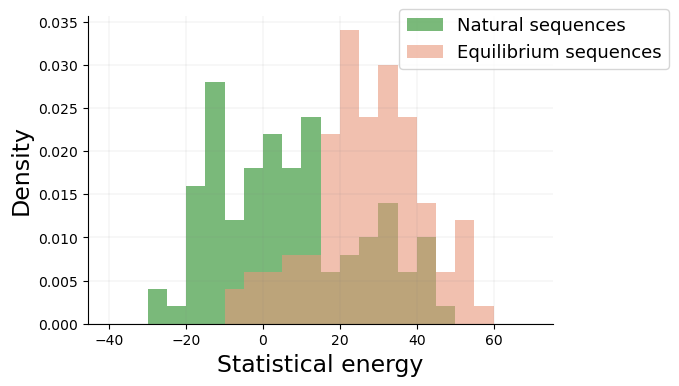

In [99]:
bins = collect(-40:5:70)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
matplotlib.pyplot.grid(color="grey", linestyle="-", linewidth=0.3, alpha = 0.3)


plt.hist(en_nat_trim, bins = bins, alpha = 0.6, 
label = "Natural sequences", density=true, color = "forestgreen")
plt.hist(en, bins = bins, alpha = 0.6, density= true, 
label = "Equilibrium sequences", color = "darksalmon")
plt.xlabel("Statistical energy", fontsize = 17)
plt.ylabel("Density", fontsize = 17)
plt.legend(bbox_to_anchor=(0.65, 1.05), loc="upper left", fontsize = 13)
plt.savefig("../img/paper_PNAS/DBD/energies", bbox_inches = "tight", dpi = 200)

## Gap profile

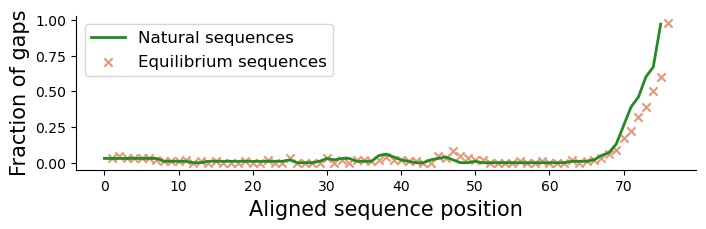

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (8, 2))
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)


gaps_freq_nat = [sum(trimmed_nat[:,i] .== 21) for i in 1:N] ./ length(trimmed_nat[:,1])
gaps_freq = [sum(step_matrices[end][:,i] .== 21) for i in 1:N] ./ length(step_matrices[end][:,1])
r_gap =round.(corspearman(gaps_freq, gaps_freq_nat), digits = 2)
plt.plot(gaps_freq_nat, label ="Natural sequences", color = "forestgreen", linewidth = 2)
plt.scatter( collect(1:length(gaps_freq)), gaps_freq, label = "Equilibrium sequences", color = "darksalmon", marker = "x", s = 35)


plt.legend(fontsize = 12)
plt.xlabel("Aligned sequence position", fontsize = 15)
plt.ylabel("Fraction of gaps", fontsize = 15)
plt.savefig("../img/paper_PNAS/DBD/gap_frequency", bbox_inches = "tight", dpi = 200)
;
